In [1]:
import numpy as np
import numpy.linalg as la
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import torch
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

print(torch.cuda.is_available())
torch.set_default_device('cuda:0')

True


In [292]:
# trial data
data = np.load('./data/sample_photostim_0113.npy', allow_pickle = True).item()
#data = np.load('./data/photostim_0404/photostim_0404_date_070623.npy', allow_pickle=True).item()
y = data['y']
u = data['u']
num_trials = y.shape[0]
num_steps = y.shape[1]
num_neurons = y.shape[2]
T_before = 4
T_after_start = 9
T_after_end = 13
y_before = np.mean(y[:,:T_before,:],axis = 1)
y_after = np.mean(y[:,T_after_start:T_after_end,:],axis = 1)

y_session = data['y_session']
u_session = data['u_session']

y_before = data['y_before'] / 1000
y_after = data['y_after'] / 1000
u = data['u']
d = 663

# linear interpolation of data
# y_session_interp = y_session.copy()
# for i in range(y_session.shape[1]):
#     nan_start = -1
#     nan_stop = -1
#     for j in range(y_session.shape[0]):
#         if nan_start == -1 and np.isnan(y_session_interp[j,i]):
#             nan_start = j - 1
#         if nan_start != -1 and not np.isnan(y_session_interp[j,i]):
#             nan_stop = j
#         if nan_start != -1 and nan_stop != -1:
#             slope = y_session_interp[nan_stop,i] - y_session_interp[nan_start,i]
#             for k in range(nan_stop - nan_start - 1):
#                 y_session_interp[nan_start + k + 1,i] = slope*k/(nan_stop-nan_start-1) + y_session_interp[nan_start,i]
#             nan_start = -1
#             nan_stop = -1

In [216]:
data = np.load('./data/photostim_0404/photostim_0404_date_070623.npy', allow_pickle=True).item()

y_session = data['y_session']
u_session = data['u_session']
print(u_session.shape)
u_indices = []
for i in range(u_session.shape[0]):
    if np.sum(u_session[i,:]) > 0:
        if (i-1 not in u_indices) and (i-2 not in u_indices):
            u_indices.append(i)

y_before = []
y_after = []
u = []
for i in range(len(u_indices)):
    if i > 0:
        t_start = u_indices[i] - 3
        t_stop = u_indices[i]
        y_before.append(np.mean(y_session[t_start:t_stop,:],axis=0))
        u.append(u_session[t_stop,:])
        
        t_start = u_indices[i] + 3
        if i < len(u_indices) - 1:
            t_stop = u_indices[i+1] - 3
        y_after.append(np.mean(y_session[t_start:t_stop,:],axis=0))
y_before = np.array(y_before[:-1]) / 1000
y_after = np.array(y_after[:-1]) / 1000
u = np.array(u[:-1])
d = 633

print(np.sum(np.isnan(y_before.flatten())))
print(np.sum(np.isnan(y_after.flatten())))
print(y_before.shape,y_after.shape,u.shape)

(29570, 633)
0
0
(2052, 633) (2052, 633) (2052, 633)


In [293]:
split_idx = int(0.8*y_before.shape[0])
y_before_train = y_before[0:split_idx,:]
y_before_test = y_before[split_idx:,:]
y_after_train = y_after[0:split_idx,:]
y_after_test = y_after[split_idx:,:]
u_train = u[0:split_idx,:]
u_test = u[split_idx:,:]

In [218]:
patterns = []
patterns_full = []
pattern_count = []
pattern_idx = []
pattern_length = []

start = -10
for t in range(u_session.shape[0]):
    if np.sum(np.abs(u_session[t,:])) > 0 and t > start + 4:
        idx = np.linspace(0,d-1,d).astype(int)
        on = u_session[t,:] > 0
        pattern = np.array(idx[on])
        start = t
        found = False
        for i in range(len(patterns)):
            if len(pattern) == len(patterns[i]):
                if np.linalg.norm(pattern - patterns[i]) == 0:
                    pattern_count[i] += 1
                    pattern_idx[i].append(t)
                    found = True
                    break
        if found is False:
            patterns.append(pattern)
            pattern_count.append(1)
            pattern_idx.append([t])
            pattern_length.append(len(pattern))
            patterns_full.append(u_session[t,:].flatten())

neuron_pattern = np.zeros(d)
for i in range(d):
    for p in patterns:
        if i in p:
            neuron_pattern[i] += 1

In [294]:
# patterns on one-step data

patterns = []
patterns_full = []
pattern_count = []
pattern_idx = []
pattern_length = []

start = -10
for t in range(u.shape[0]):
    idx = np.linspace(0,d-1,d).astype(int)
    on = u[t,:] > 0
    pattern = np.array(idx[on])
    start = t
    found = False
    for i in range(len(patterns)):
        if len(pattern) == len(patterns[i]):
            if np.linalg.norm(pattern - patterns[i]) == 0:
                pattern_count[i] += 1
                pattern_idx[i].append(t)
                found = True
                break
    if found is False:
        patterns.append(pattern)
        pattern_count.append(1)
        pattern_idx.append([t])
        pattern_length.append(len(pattern))
        patterns_full.append(u[t,:].flatten())

neuron_pattern = np.zeros(d)
for i in range(d):
    for p in patterns:
        if i in p:
            neuron_pattern[i] += 1

In [295]:
import copy
held_out_patterns = np.random.choice(range(100), 20, replace=False).astype(int)
held_out_time = 0
for i in held_out_patterns:
    held_out_time += pattern_count[i]
print(held_out_time / y_before.shape[0])
test_times = []
for i in held_out_patterns:
    test_times.extend(copy.copy(pattern_idx[i]))

d = y_before.shape[1]
T = y_before.shape[0]
y_before_train = np.zeros((T-held_out_time,d))
y_before_test = np.zeros((held_out_time,d))
y_after_train = np.zeros((T-held_out_time,d))
y_after_test = np.zeros((held_out_time,d))
u_train = np.zeros((T-held_out_time,d))
u_test = np.zeros((held_out_time,d))

test_idx = 0
train_idx = 0
new_train_times = np.zeros(T).astype(int)
for t in range(T):
    if t in test_times:
        y_before_test[test_idx,:] = y_before[t,:]
        y_after_test[test_idx,:] = y_after[t,:]
        u_test[test_idx,:] = u[t,:]
        test_idx += 1
    else:
        y_before_train[train_idx,:] = y_before[t,:]
        y_after_train[train_idx,:] = y_after[t,:]
        u_train[train_idx,:] = u[t,:]
        new_train_times[t] = train_idx
        train_idx += 1

0.18587521663778164


In [296]:
patterns_train = []
patterns_full_train = []
pattern_count_train = []
pattern_idx_train = []
pattern_length_train = []

new_train_times = np.zeros(T).astype(int)
train_idx = 0
for t in range(T):
    if t not in test_times:
        new_train_times[t] = train_idx
        train_idx += 1

total = 0
for i in range(100):
    if i in held_out_patterns:
        asdf = 0
    else:
        patterns_train.append(patterns[i])
        patterns_full_train.append(patterns_full[i])
        pattern_count_train.append(pattern_count[i])
        pattern_length_train.append(pattern_length[i])
        
        new_t = []
        for t in pattern_idx[i]:
            new_t.append(new_train_times[t])
        total += pattern_count[i]
        pattern_idx_train.append(new_t)
print(train_idx,total,T-len(test_times))

1879 1879 1879


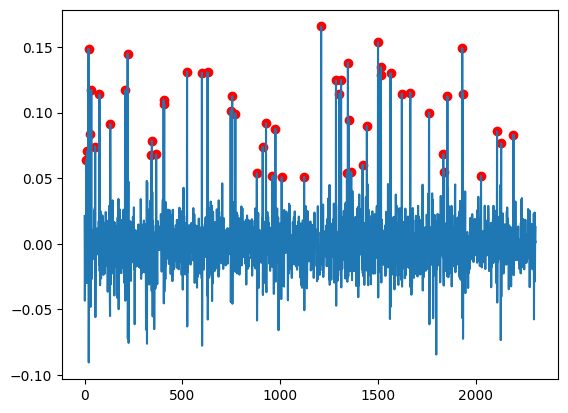

In [300]:
y_diff = y_after - y_before
neuron = 5
mean_threshold = np.median(y_diff[:,neuron])
lower_tail_idx = (y_diff[:,neuron] < mean_threshold)
lower_tail_data = y_diff[lower_tail_idx,neuron]
lower_tail_std = np.std(lower_tail_data)
spike_threshold = mean_threshold + 4*lower_tail_std

spiking = (y_diff[:,neuron] > spike_threshold)
#spiking = lower_tail_idx
plt.plot(y_diff[:,neuron])
#plt.plot(x_pred[:T,neuron])
idx = np.linspace(0,len(y_diff[:,neuron])-1,len(y_diff[:,neuron]))
plt.scatter(idx[spiking],y_diff[spiking,neuron],color='r')

In [301]:
def compute_ROC(Ahat):
    tpr2 = []
    fpr2 = []
    thresholds = np.linspace(-2,5,15)
    
    pred = Ahat @ np.concatenate((u_test.T,y_before_test.T))
    pred = pred.T

    missed_spikes = []
    pred_spikes = []

    for thresholds_idx in range(len(thresholds)):
        tp_total = 0
        fp_total = 0
        p_total = 0
        n_total = 0

        tpr = 0
        fpr = 0
        tpr_c = 0
        fpr_c = 0
        for neuron in range(y_before_test.shape[1]):
            y_diff = y_after - y_before
            mean_threshold = np.median(y_diff[:,neuron])
            lower_tail_idx = (y_diff[:,neuron] < mean_threshold)
            lower_tail_data = y_diff[lower_tail_idx,neuron]
            lower_tail_std = np.std(lower_tail_data)
            detect_spike_threshold = mean_threshold + thresholds[thresholds_idx]*lower_tail_std
            true_spike_threshold = mean_threshold + 4*lower_tail_std

            predicted_spikes = (pred[:,neuron] - y_before_test[:,neuron] > detect_spike_threshold)
            true_spikes = (y_after_test[:,neuron] - y_before_test[:,neuron] > true_spike_threshold)
            tp_total += np.sum(np.logical_and(predicted_spikes,true_spikes))
            fp_total += np.sum(np.logical_and(predicted_spikes,~true_spikes))
            p_total += np.sum(true_spikes)
            n_total += np.sum(~true_spikes)
#             if np.sum(true_spikes) > 0:
#                 tpr += np.sum(np.logical_and(predicted_spikes,true_spikes)) / np.sum(true_spikes)
#                 tpr_c += 1
#             if np.sum(~true_spikes) > 0:
#                 fpr += np.sum(np.logical_and(predicted_spikes,~true_spikes)) / np.sum(~true_spikes)
#                 fpr_c += 1

        tpr2.append(tp_total / p_total)
        fpr2.append(fp_total / n_total)
#         tpr2.append(tpr / tpr_c)
#         fpr2.append(fpr / fpr_c)
    return tpr2, fpr2

# Input optimization

In [32]:
def simplex_proj(dist):
    n = len(dist)
    dist.clamp_(min=0, max=1)
    sort_idx = torch.argsort(dist, descending=True)
    running_sum = 0
    max_j = 0
    max_sum = 0
    for j in range(n):
        uij = dist[sort_idx[j]]
        running_sum += uij
        if uij - (running_sum - 1) / (j+1) > 0:
            max_j = j + 1
            max_sum = running_sum.clone()
    theta = (max_sum - 1) / max_j
    dist_proj = dist - theta
    dist_proj.clamp_(min=0)
    dist.data = dist_proj
    return dist

def design_inputs_constrained(transfer_est, 
        inputs,
        verbose=True, 
        n_iters=1000, 
        k=50, 
        num_random=None,
        cov0=None):
    transfer_est = torch.tensor(transfer_est).float()
    d = transfer_est.shape[0]
    n = len(inputs)
    inputs_mat = torch.zeros(d,d,n).float()
    for i in range(n):
        u_torch = torch.tensor(inputs[i]).float()
        inputs_mat[:,:,i] = torch.outer(u_torch, u_torch)
    input_dist = torch.randn(n).float()
    input_dist = simplex_proj(input_dist)
    input_dist.requires_grad_()
    optimizer = optim.Adam([input_dist], lr=0.1)
    
    if num_random is not None:
        u_random = np.random.randn(d,num_random)
        if sphere_normalization:
            u_random = np.sqrt(num_random) * u_random / np.linalg.norm(u_random, 'fro')
        u_random = torch.tensor(u_random, dtype=torch.float32)
        if not sphere_normalization:
            u_random = project_inputs(u_random, max_on=l1_constraint)
            u_random.clamp_(min=0,max=1)
        cov_random = u_random @ u_random.T / num_random
    if cov0 is not None:
        cov0 = torch.tensor(cov0).float()

    _,_,V_true = torch.linalg.svd(transfer_est)
    V_true = torch.tensor(V_true[0:k,:], dtype=torch.float32)
    min_inputs = None
    min_loss = 1e10
    loss_vals = []
    
    for n in range(n_iters):
        optimizer.zero_grad()
        cov_reg = 0.000001 * torch.eye(d)
        if num_random is not None:
            cov_reg += cov_random
        if cov0 is not None:
            cov_reg += cov0
        
        cov = inputs_mat @ input_dist
        loss = torch.trace(torch.linalg.inv( V_true @ (cov + cov_reg) @ V_true.T))
        loss_val = loss.item()
        loss.backward()
        optimizer.step()
        with torch.no_grad():
            input_dist = simplex_proj(input_dist)
        if np.mod(n,10) == 0 and verbose:
            print(n,loss_val,torch.min(input_dist),torch.max(input_dist),input_dist.sum())
        loss_vals.append(loss_val)
        if loss_val < min_loss:
            min_loss = loss_val
            min_inputs = input_dist.clone()
    #if verbose:
    plt.plot(loss_vals)
    plt.title("input optimization loss")
    plt.show()

    return min_inputs.detach().cpu().numpy()


U,S,V = torch.linalg.svd(0.1*torch.randn(663,663))
S[50:0] = 0
T = U @ torch.diag(S) @ V

patterns2 = []
for i in range(1000):
    patterns2.append(torch.randn(663))
x = design_inputs_constrained(T, patterns2, k=1)

0 0.8647631406784058 tensor(0., device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0056, device='cuda:0', grad_fn=<MaxBackward1>) tensor(1.0010, device='cuda:0', grad_fn=<SumBackward0>)
10 0.8594461679458618 tensor(0., device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0056, device='cuda:0', grad_fn=<MaxBackward1>) tensor(1.0003, device='cuda:0', grad_fn=<SumBackward0>)
20 0.859699547290802 tensor(0., device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0056, device='cuda:0', grad_fn=<MaxBackward1>) tensor(1.0006, device='cuda:0', grad_fn=<SumBackward0>)
30 0.8593385219573975 tensor(0., device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0056, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9993, device='cuda:0', grad_fn=<SumBackward0>)
40 0.8611452579498291 tensor(0., device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0056, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9992, device='cuda:0', grad_fn=<SumBackward0>)
50 0.8600722551345825 tensor(0., device='cuda:0', grad_fn=<MinBackward1>

KeyboardInterrupt: 

0 tensor(1107.6042, device='cuda:0')
100 tensor(790.7330, device='cuda:0')
200 tensor(717.7290, device='cuda:0')
300 tensor(705.6298, device='cuda:0')
400 tensor(700.6843, device='cuda:0')
500 tensor(698.1777, device='cuda:0')
600 tensor(697.0323, device='cuda:0')
700 tensor(696.4765, device='cuda:0')
800 tensor(695.7872, device='cuda:0')
900 tensor(695.8350, device='cuda:0')
1000 tensor(695.5071, device='cuda:0')
1100 tensor(695.2546, device='cuda:0')
1200 tensor(695.1901, device='cuda:0')
1300 tensor(695.0075, device='cuda:0')
1400 tensor(694.8682, device='cuda:0')
1500 tensor(694.8796, device='cuda:0')
1600 tensor(694.7542, device='cuda:0')
1700 tensor(694.7292, device='cuda:0')
1800 tensor(694.6989, device='cuda:0')
1900 tensor(694.6318, device='cuda:0')


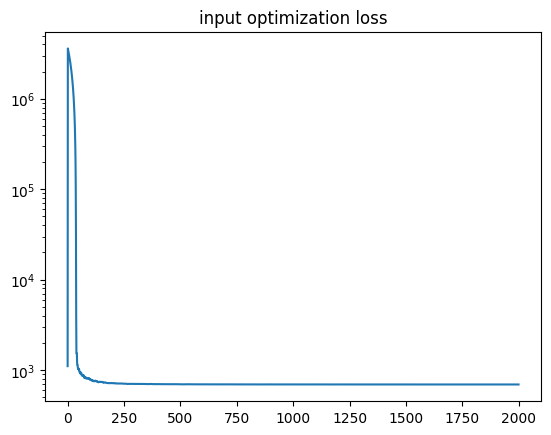

1107.6042 694.69006


In [269]:
def design_inputs_fw(transfer_est, 
        inputs,
        verbose=True, 
        n_iters=1000, 
        k=50, 
        num_random=None,
        cov0=None):
    transfer_est = torch.tensor(transfer_est).float()
    d = transfer_est.shape[0]
    n = len(inputs)
    inputs_dist = torch.ones(n).float() / n
    #inputs_dist[0] = 1.0

    _,_,V_true = torch.linalg.svd(transfer_est)
    V_true = torch.tensor(V_true[0:k,:], dtype=torch.float32)
    inputstil = []
    for i in range(n):
        inputstil.append(V_true @ torch.tensor(inputs[i]).float())
    
    min_inputs = None
    min_loss = 1e10
    loss_vals = []
    A = torch.zeros(k,k).float()
    for i in range(n):
        A += torch.outer(inputstil[i],inputstil[i]) / n
    
    for iter_idx in range(n_iters):
        max_input = -1
        max_val = 0
        A_inv = torch.linalg.inv(A + 0.00001 * torch.eye(k))
        A_inv_sq = A_inv @ A_inv
        for i in range(n):
            val = inputstil[i].T @ A_inv_sq @ inputstil[i]
            if val > max_val:
                max_val = val
                max_input = i
        gamma = 2/(iter_idx+2)
        A = (1 - gamma) * A + gamma * torch.outer(inputstil[max_input], inputstil[max_input])
        new_dist = torch.zeros(n)
        new_dist[max_input] = 1.0
        inputs_dist = (1 - gamma) * inputs_dist + gamma * new_dist
        
        loss = torch.trace(A_inv)
        
        if np.mod(iter_idx,100) == 0 and verbose:
            print(iter_idx,loss)
        loss_vals.append(loss.detach().cpu().numpy())
    #if verbose:
    plt.plot(loss_vals)
    plt.yscale('log')
    plt.title("input optimization loss")
    plt.show()
    
    print(loss_vals[0],loss_vals[-1])

    return inputs_dist.detach().cpu().numpy()


# U,S,V = torch.linalg.svd(0.1*torch.randn(663,663))
# S[50:0] = 0
# T = U @ torch.diag(S) @ V

# patterns2 = []
# for i in range(700):
#     patterns2.append(torch.randn(663))
T = torch.tensor(B_gt).float()
x = design_inputs_fw(T, patterns_full_train, n_iters=2000, k=37)
#plt.plot(x)
#print(np.max(x),np.min(x),np.sum(x))

0.111754075 0.0 0.9999999
52


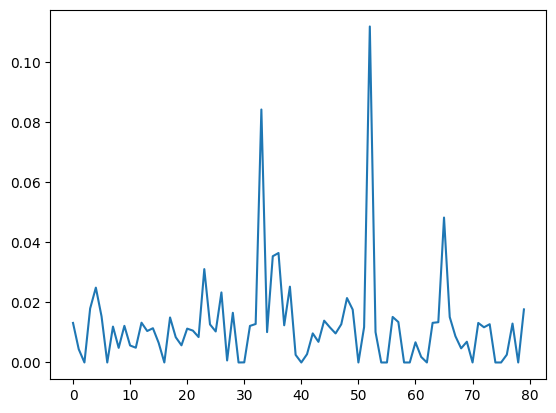

In [270]:
plt.plot(x)
print(np.max(x),np.min(x),np.sum(x))
print(np.random.choice(range(len(x)), p=x))

# Estimate GT model

In [302]:
def compute_test_mse(A):
    pred = A @ np.concatenate((u_test.T,y_before_test.T))
    # pred = A @ (u_test.T)
    # pred = A @ (y_before_test.T)
    return np.linalg.norm(pred - y_after_test.T, 2)**2 / y_after_test.shape[0]

def compute_train_mse(A):
    pred = A @ np.concatenate((u_train.T,y_before_train.T))
    # pred = A @ (u_test.T)
    # pred = A @ (y_before_test.T)
    return np.linalg.norm(pred - y_after_train.T, 2)**2 / y_after_train.shape[0]

In [303]:
X = []
Y = []
for i in range(y_before_train.shape[0]):
    X.append(np.concatenate((u_train[i,:].flatten(),y_before_train[i,:].flatten())))
    #X.append(u_train[i,:].flatten())
    #X.append(y_before_train[i,:].flatten())
    Y.append(y_after_train[i,:].flatten())

(663, 1326)
16.90453671534551
0.18433888148676378


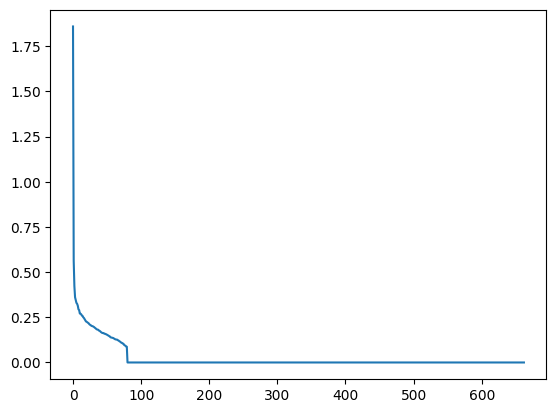

In [304]:
import importlib
import estimation_procedures as est
importlib.reload(est)

G_ls = est.estimate_ls(X,Y)
mse_ls = compute_test_mse(G_ls)
mse_train_ls = compute_train_mse(G_ls)
print(G_ls.shape)
B_ls = G_ls[:,0:d]
A_ls = G_ls[:,d:]
_,S,_ = la.svd(B_ls[:,0:d])
print(S.sum())
print(mse_ls)

A_gt = A_ls
B_gt = B_ls.copy()

plt.plot(S)

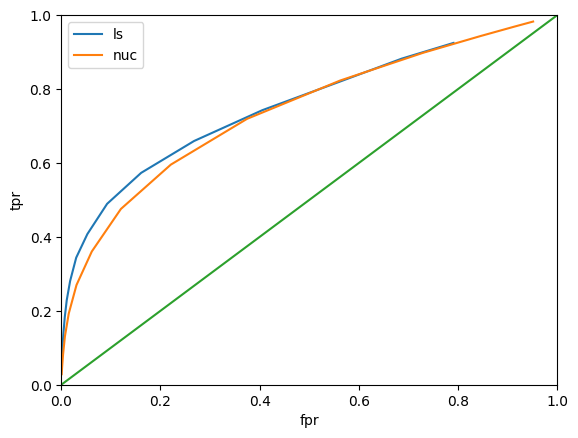

In [307]:
# tpr_ls, fpr_ls = compute_ROC(G_ls)
#tpr_active2, fpr_active2 = compute_ROC(np.concatenate((B_nuc_active,A_nuc_active), axis=1))
#tpr_active_lr, fpr_active_lr = compute_ROC(np.concatenate((B_lr_active,A_lr_active), axis=1))
# tpr_passive, fpr_passive = compute_ROC(np.concatenate((B_nuc_passive,A_nuc_passive), axis=1))

#tpr_active, fpr_active = compute_ROC(G_ls_active)
#tpr_passive, fpr_passive = compute_ROC(G_ls_passive)
#tpr_ls, fpr_ls = compute_ROC(G_ls)
tpr_nuc, fpr_nuc = compute_ROC(np.concatenate((B_nuc,A_nuc), axis=1))


# plt.plot(fpr_ls,tpr_ls,label='ls')
# plt.plot(fpr_active,tpr_active,label='active')
# plt.plot(fpr_active2,tpr_active2,label='active nuc')
# plt.plot(fpr_active_lr,tpr_active_lr,label='active lowrank')
# plt.plot(fpr_passive,tpr_passive,label='passive')
plt.plot(fpr_ls,tpr_ls,label='ls')
plt.plot(fpr_nuc,tpr_nuc,label='nuc')
plt.plot([0,1],[0,1])
plt.xlim([0,1])
plt.ylim([0,1])
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.legend()

(0.0, 0.6)

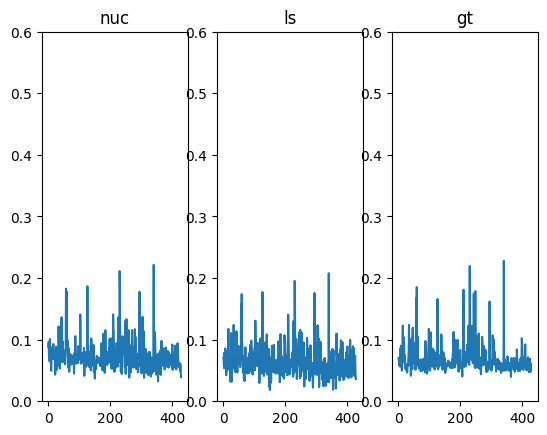

In [310]:
pred_nuc = np.concatenate((B_nuc,A_nuc), axis=1) @ np.concatenate((u_test.T,y_before_test.T))
pred_ls = G_ls @ np.concatenate((u_test.T,y_before_test.T))

neuron = 10
plt.subplot(1,3,1)
plt.plot(pred_nuc[neuron,:])
plt.title('nuc')
plt.ylim([0.0,0.6])
plt.subplot(1,3,2)
plt.plot(pred_ls[neuron,:])
plt.title('ls')
plt.ylim([0.0,0.6])
plt.subplot(1,3,3)
plt.plot(y_after_test[:,neuron])
plt.title('gt')
plt.ylim([0.0,0.6])

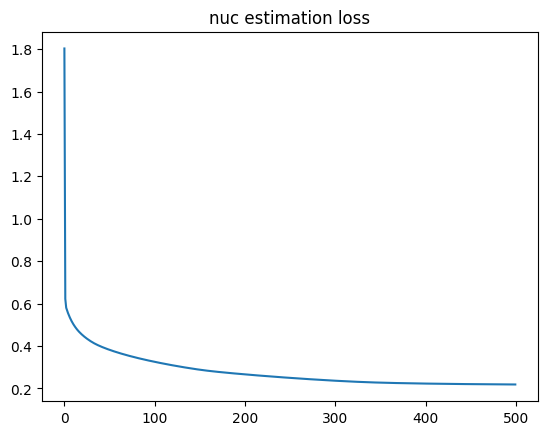

5 0.06458538930360143 0.18433888148676378


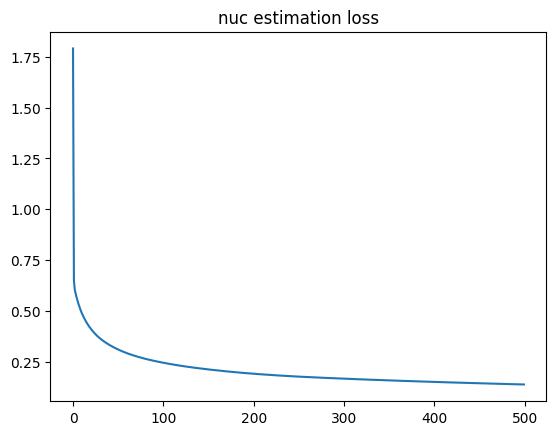

10 0.06338115634365188 0.18433888148676378
[0.06458538930360143, 0.06338115634365188] 0.18433888148676378


In [306]:
# X_nuc = []
# Y_nuc = []
# for i in range(y_before_train.shape[0]):
#     X_nuc.append(u_train[i,:].flatten())
#     Y_nuc.append(y_after_train[i,:].flatten() - A_ls @ y_before_train[i,:].flatten())

mse_nuc_vals = []
nuc_reg = [5,10] #[5,10,20,40]
for reg in nuc_reg:
    #B_nuc = est.estimate_gd_nuc_project(X_nuc,Y_nuc,reg=reg,transfer0=B_ls,n_iters=100,lr=0.0001)
    A_nuc,B_nuc = est.estimate_gd_nuc_project_AB(X,Y,reg=reg,transfer0=[A_ls,B_ls],n_iters=500,lr=0.1)
    mse_nuc_vals.append(compute_test_mse(np.concatenate((B_nuc,A_nuc), axis=1)))
    #mse_nuc_vals.append(compute_test_mse(np.concatenate((B_nuc,A_ls), axis=1)))
    print(reg,mse_nuc_vals[-1],mse_ls)
print(mse_nuc_vals,mse_ls)

In [233]:
B_gt = B_nuc.copy()

(663, 1326)
2.8727959429594874 28.244899241092227


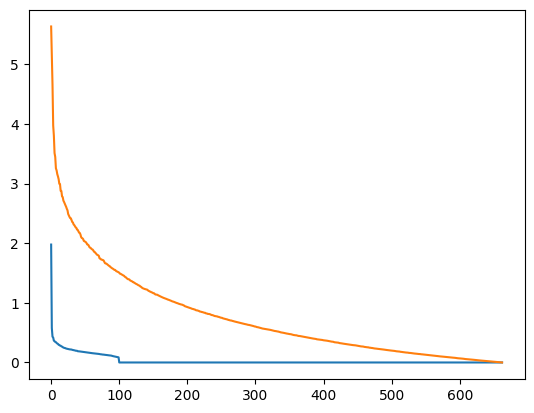

In [129]:
print(A_ls.shape)
print(la.norm(A_ls[:,0:663]),la.norm(A_ls[:,663:]))
_,S1,_ = la.svd(A_ls[:,0:663])
_,S2,_ = la.svd(A_ls[:,663:])
plt.plot(S1)
plt.plot(S2)

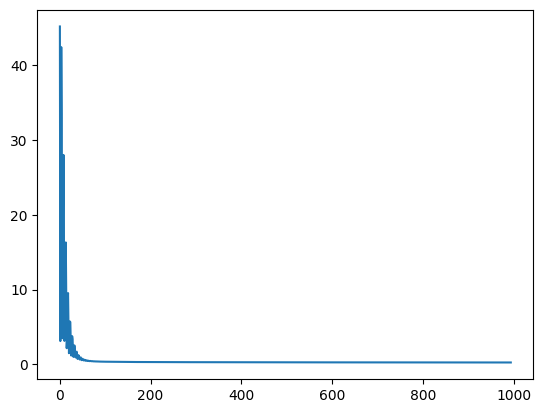

25 0.2169732903975094 0.4168397532442058


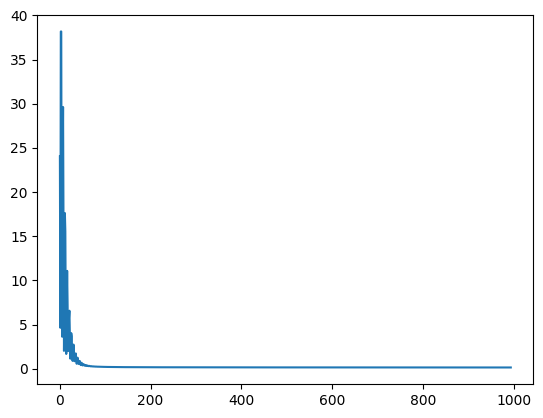

50 0.20838604380796086 0.4168397532442058


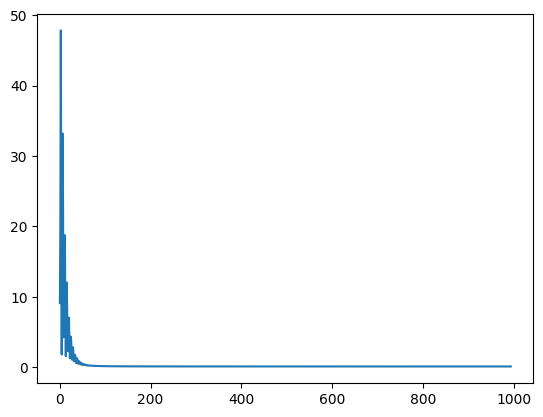

75 0.19548906699176885 0.4168397532442058


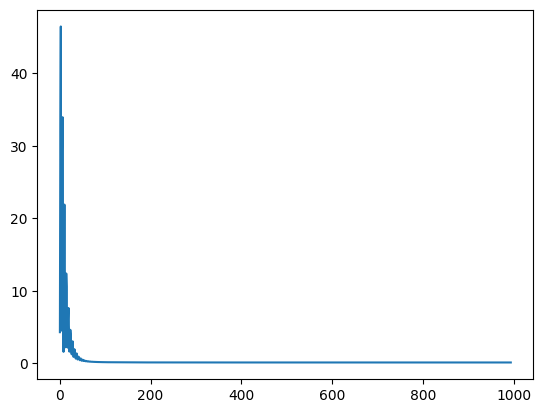

100 0.20342682060567163 0.4168397532442058


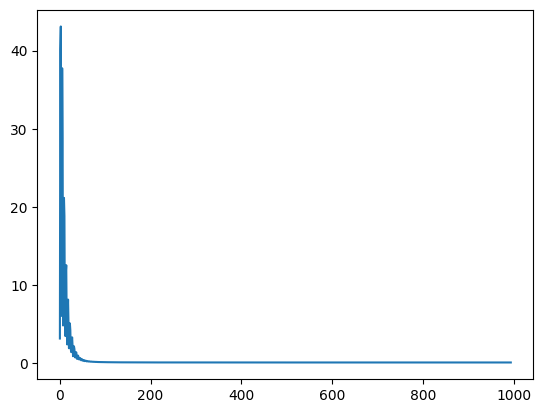

125 0.20910989154744744 0.4168397532442058
[0.2169732903975094, 0.20838604380796086, 0.19548906699176885, 0.20342682060567163, 0.20910989154744744] 0.4168397532442058


In [230]:
import importlib
import estimation_procedures as est
importlib.reload(est)

mse_nuc_vals = []
nuc_reg = [25,50,75,100,125]
#nuc_reg = [125,150]
for reg in nuc_reg:
    A_nuc,B_nuc = est.estimate_gd_lowrank_AB(X,Y,rank=reg,transfer0=[A_ls,B_ls],n_iters=1000,lr=0.01)
    mse_nuc_vals.append(compute_test_mse(np.concatenate((B_nuc,A_nuc), axis=1)))
    print(reg,mse_nuc_vals[-1],mse_ls)
    #print(compute_train_mse(np.concatenate((B_nuc,A_nuc), axis=1)), mse_train_ls)
print(mse_nuc_vals,mse_ls)

# Active learning

0
10


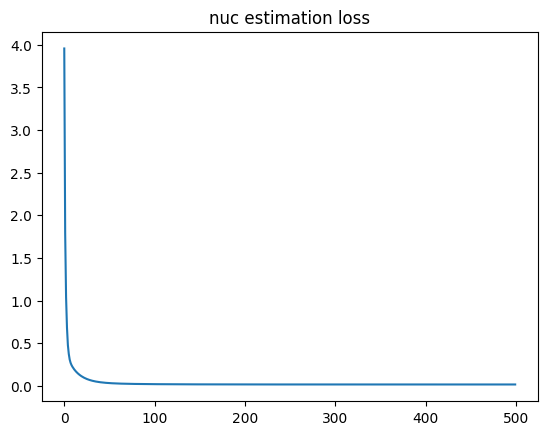

In [286]:
e_passive = np.zeros(3)
e_passive_nuc = np.zeros(3)
e_passive_lr = np.zeros(3)
record_interval = 10

fpr_passive = []
tpr_passive = []
for i in range(3):
    fpr_passive.append(np.zeros(15))
    tpr_passive.append(np.zeros(15))

num_trials = 1
for trial_idx in range(num_trials):
    X = []
    Y = []
    e_idx = 0
    print(trial_idx)
    
    input_cov = 0.000001 * np.eye(100)
    available_inputs = np.ones(100).astype(bool)
    input_idx = np.zeros(100).astype(int)
    used_t = np.zeros(u_train.shape[0]).astype(bool)

    #for t in range(u_train.shape[0]):
    for t in range(11):
#         max_idx = np.random.randint(0,100)
#         while not available_inputs[max_idx]:
#             max_idx = np.random.randint(0,100)

#         input_cov += np.outer(V_true @ patterns_full[max_idx], V_true @ patterns_full[max_idx])
#         idx_t = pattern_idx[max_idx][input_idx[max_idx]]
#         input_idx[max_idx] += 1
#         if input_idx[max_idx] >= len(pattern_idx[max_idx]):
#             available_inputs[max_idx] = False
        idx_t = np.random.randint(0,u_train.shape[0])
        while used_t[idx_t]:
            idx_t = np.random.randint(0,u_train.shape[0])
        used_t[idx_t] = True

        X.append(np.concatenate((u_train[idx_t,:],y_before_train[idx_t,:].flatten())))
        Y.append(y_after_train[idx_t,:].flatten())

        if np.mod(t, record_interval) == 0 and t > 0:
            print(t)
#             G_ls_passive = est.estimate_ls(X,Y)
#             tpr, fpr = compute_ROC(G_ls_passive)
#             tpr_passive[e_idx] += np.array(tpr) / num_trials
#             fpr_passive[e_idx] += np.array(fpr) / num_trials
            #e_passive.append(compute_test_mse(np.concatenate((B_ls,A_gt), axis=1)) - mse_ls)
            #e_passive.append(compute_test_mse(G_ls) - mse_ls)
#             e_passive[e_idx] += compute_test_mse(G_ls) / num_trials
#             A_ls = G_ls[:,663:]
#             B_ls = G_ls[:,0:663]
            A_nuc_passive,B_nuc_passive = est.estimate_gd_nuc_project_AB(X,Y,reg=5,transfer0=[A_ls,B_ls],n_iters=500,lr=0.1)
            e_passive_nuc[e_idx] += compute_test_mse(np.concatenate((B_nuc_passive,A_nuc_passive), axis=1)) / num_trials
            tpr, fpr = compute_ROC(np.concatenate((B_nuc_passive,A_nuc_passive), axis=1))
            tpr_passive[e_idx] += np.array(tpr) / num_trials
            fpr_passive[e_idx] += np.array(fpr) / num_trials
#             A_lr,B_lr = est.estimate_gd_lowrank_AB(X,Y,rank=50,transfer0=[A_ls,B_ls],n_iters=500,lr=0.01)
#             e_passive_lr[e_idx] += compute_test_mse(np.concatenate((B_lr,A_lr), axis=1)) / num_trials
            e_idx += 1
            #print(e_passive,e_passive_nuc)
        
# B_ls = est.estimate_ls(X,Y)
# #e_passive.append(compute_test_mse(np.concatenate((B_ls,A_gt), axis=1)) - mse_ls)
# e_passive.append(compute_test_mse(B_ls) - mse_ls)

7.241843064400171

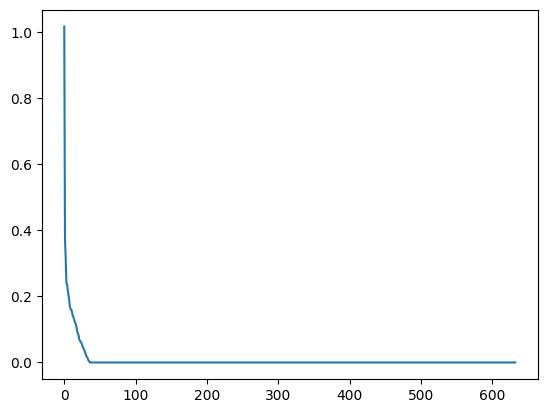

In [283]:
_,S,_ = la.svd(B_gt)
plt.plot(S)
u_train.shape[0]
compute_test_mse(np.zeros_like(np.concatenate((B_nuc_passive,A_nuc_passive), axis=1)))

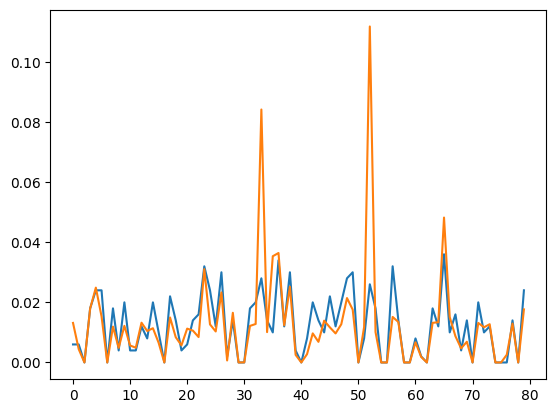

0 1000


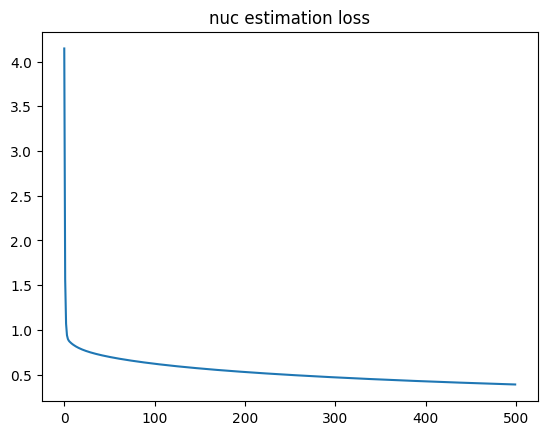

In [271]:
_,_,V = la.svd(B_gt)
k = 37
V_true = V[0:k,:]

e_active = np.zeros(3)
e_active_nuc = np.zeros(3)
e_active_lr = np.zeros(3)
record_interval = 1000

fpr_active = []
tpr_active = []
for i in range(3):
    fpr_active.append(np.zeros(15))
    tpr_active.append(np.zeros(15))

num_trials = 1
num_inputs = len(pattern_idx_train)

counts = np.zeros(len(x))

for trial_idx in range(num_trials):
    X = []
    Y = []
    input_cov = 0.000001 * np.eye(k)
    input_full = 0.000001 * np.eye(d)
    available_inputs = np.ones(num_inputs).astype(bool)
    input_idx = np.zeros(num_inputs).astype(int)
    used_t = np.zeros(u_train.shape[0]).astype(bool)
    e_idx = 0

    #for t in range(u_train.shape[0]):
    for t in range(1001):
        if np.mod(t,2) > 0:
#             input_cov_inv = la.inv(input_cov)
#             input_cov_inv_sq = input_cov_inv @ input_cov_inv
#             max_idx = -1
#             max_val = -1
#             for i in range(num_inputs):
#                 if available_inputs[i]:
#                     u = V_true @ patterns_full_train[i]
#                     val = u.T @ input_cov_inv_sq @ u
#                     if val > max_val:
#                         max_val = val
#                         max_idx = i


            max_idx = None
            for i in range(1000):
                temp_idx = np.random.choice(range(len(x)), p=x)
                if available_inputs[temp_idx]:
                    max_idx = temp_idx
                    break
            if max_idx is None:
                max_idx = np.random.choice(range(len(x)))
                while not available_inputs[max_idx]:
                    max_idx = np.random.choice(range(len(x)))


            counts[max_idx] += 1
            idx_t = pattern_idx_train[max_idx][input_idx[max_idx]]
            used_t[idx_t] = True
            input_idx[max_idx] += 1
            if input_idx[max_idx] >= len(pattern_idx_train[max_idx]):
                available_inputs[max_idx] = False
                input_idx[max_idx] = 0
        else:
#             input_cov_inv = la.inv(input_full)
#             input_cov_inv_sq = input_cov_inv @ input_cov_inv
#             max_idx = -1
#             max_val = -1
#             for i in range(num_inputs):
#                 if available_inputs[i]:
#                     u = patterns_full_train[i]
#                     val = u.T @ input_cov_inv_sq @ u
#                     if val > max_val:
#                         max_val = val
#                         max_idx = i
#             idx_t = pattern_idx_train[max_idx][input_idx[max_idx]]
#             used_t[idx_t] = True
#             input_idx[max_idx] += 1
#             if input_idx[max_idx] >= len(pattern_idx_train[max_idx]):
#                 available_inputs[max_idx] = False
            #max_idx = np.random.randint(0,100)
#             max_idx = np.argmin(input_idx)
#             while not available_inputs[max_idx]:
#                 max_idx = np.random.randint(0,100)

            idx_t = np.random.randint(0,u_train.shape[0])
            while used_t[idx_t]:
                idx_t = np.random.randint(0,u_train.shape[0])
            used_t[idx_t] = True
            for i in range(num_inputs):
                if idx_t in pattern_idx_train[i]:
                    input_idx[i] += 1
                    if input_idx[i] >= len(pattern_idx_train[i]):
                        available_inputs[i] = False

#         input_cov += np.outer(V_true @ patterns_full[max_idx], V_true @ patterns_full[max_idx])
#         idx_t = pattern_idx[max_idx][input_idx[max_idx]]
#         input_idx[max_idx] += 1
#         if input_idx[max_idx] >= len(pattern_idx[max_idx]):
#             available_inputs[max_idx] = False

        input_cov += np.outer(V_true @ u_train[idx_t,:], V_true @ u_train[idx_t,:])
        input_full += np.outer(u_train[idx_t,:], u_train[idx_t,:])
        X.append(np.concatenate((u_train[idx_t,:],y_before_train[idx_t,:].flatten())))
        Y.append(y_after_train[idx_t,:].flatten())

        if np.mod(t, record_interval) == 0 and t > 0:
            plt.plot(counts / np.sum(counts))
            plt.plot(x)
            plt.show()
            
            print(trial_idx,t)
#             G_ls_active = est.estimate_ls(X,Y)
#             tpr, fpr = compute_ROC(G_ls_active)
#             tpr_active[e_idx] += np.array(tpr) / num_trials
#             fpr_active[e_idx] += np.array(fpr) / num_trials
            #e_passive.append(compute_test_mse(np.concatenate((B_ls,A_gt), axis=1)) - mse_ls)
#             e_active[e_idx] += compute_test_mse(G_ls)/num_trials
#             A_ls = G_ls[:,663:]
#             B_ls = G_ls[:,0:663]
#             A_lr_active,B_lr_active = est.estimate_gd_lowrank_AB(X,Y,rank=50,transfer0=[A_ls,B_ls],n_iters=500,lr=0.01)
#             e_active_lr[e_idx] += compute_test_mse(np.concatenate((B_lr,A_lr), axis=1)) / num_trials
            A_nuc,B_nuc = est.estimate_gd_nuc_project_AB(X,Y,reg=5,transfer0=[A_ls,B_ls],n_iters=500,lr=0.1)
            e_active_nuc[e_idx] += compute_test_mse(np.concatenate((B_nuc,A_nuc), axis=1)) / num_trials
            tpr, fpr = compute_ROC(np.concatenate((B_nuc,A_nuc), axis=1))
            tpr_active[e_idx] += np.array(tpr) / num_trials
            fpr_active[e_idx] += np.array(fpr) / num_trials
            e_idx += 1


# B_ls = est.estimate_ls(X,Y)
# #e_passive.append(compute_test_mse(np.concatenate((B_ls,A_gt), axis=1)) - mse_ls)
# e_active.append(compute_test_mse(B_ls) - mse_ls)

passive: [0.22235571 0.         0.        ]
active: [0.10967605 0.         0.        ]


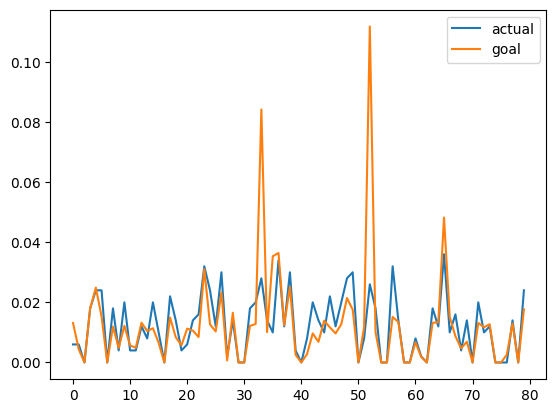

In [287]:
#plt.plot(e_passive,label='passive')
# plt.plot(e_passive_lr,label='passive lr')
# plt.plot(e_passive_nuc,label='passive nuc')
# #plt.plot(e_active,label='active')
# #plt.plot(e_active_lr,label='active lr')
# plt.plot(e_active_nuc,label='active nuc')
# plt.legend()
# plt.show()
print("passive:",e_passive_nuc)
print("active:",e_active_nuc)
plt.plot(counts / np.sum(counts), label='actual')
plt.plot(x, label='goal')
plt.legend()
plt.show()

# passive t=[100,200,300],  e=[0.1160528  0.11306062 0.1125906 ]
# passive t=[500,1000,1500],  e=[0.10871095 0.10929341 0.10827536]

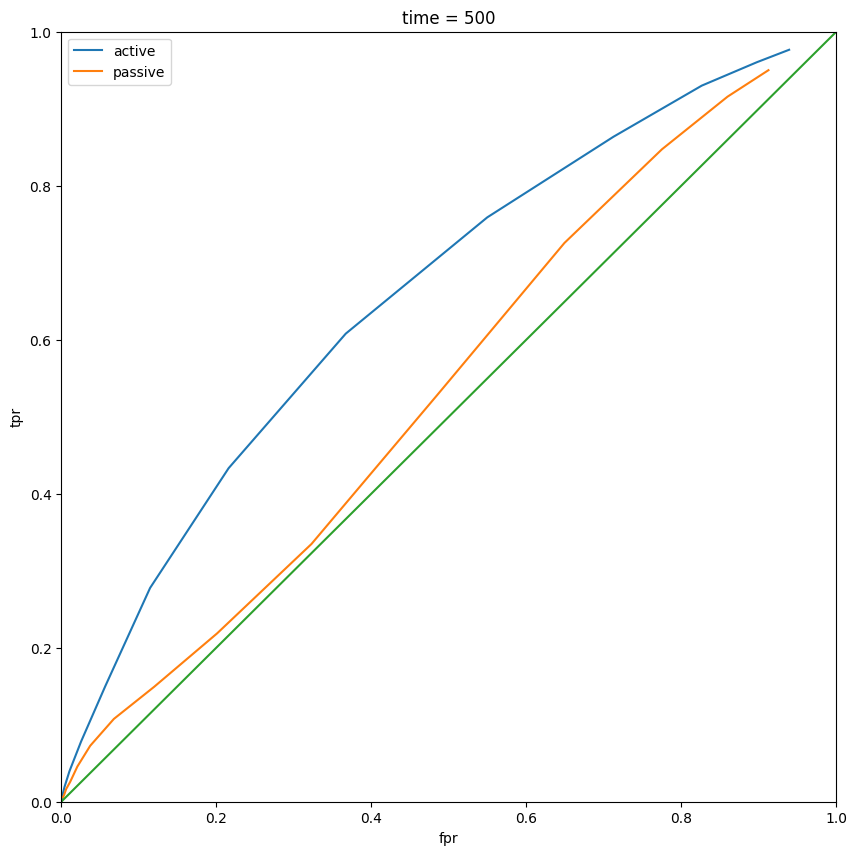

In [288]:
time = [500,1000,1500]
plt.figure(figsize=(10,10))
for i in range(1):
    #plt.subplot(1,3,i+1)
    plt.plot(fpr_active[i],tpr_active[i],label='active')
    plt.plot(fpr_passive[i],tpr_passive[i],label='passive')
    #plt.plot(fpr_passive[i+1],tpr_passive[i],label='passive 2')
    #plt.plot(fpr_passive[i+2],tpr_passive[i],label='passive 3')
    plt.plot([0,1],[0,1])
    plt.xlim([0,1])
    plt.ylim([0,1])
    plt.xlabel('fpr')
    plt.ylabel('tpr')
    plt.legend()
    plt.title('time = ' + str(time[i]))

Text(0.5, 1.0, 'time = 500')

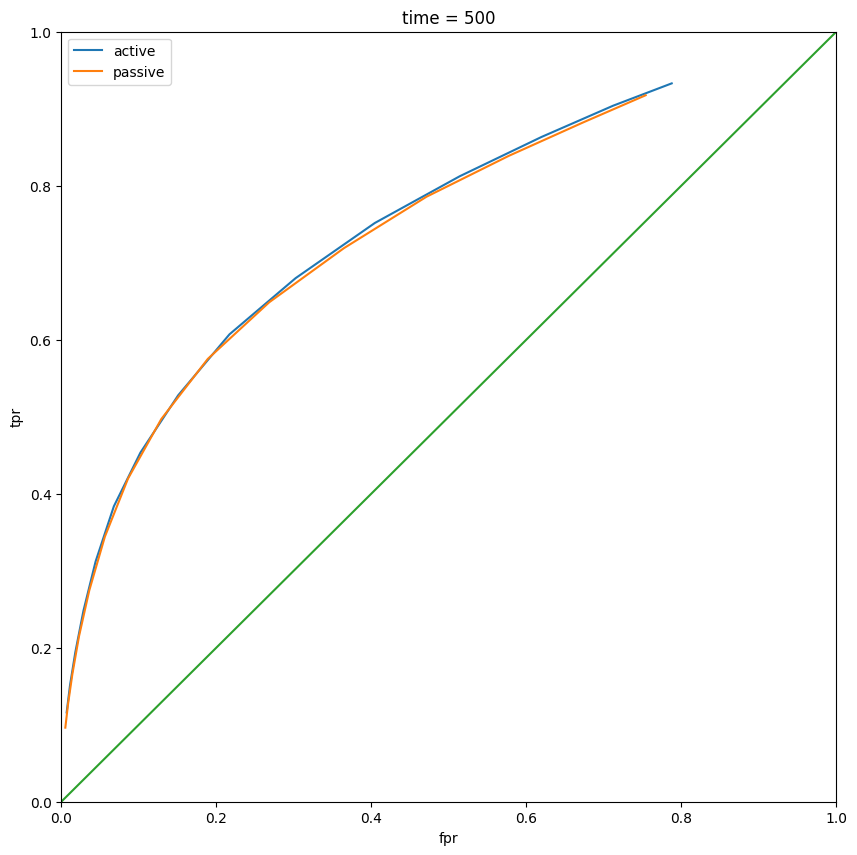

In [119]:
time = [500,1000,1500]
plt.figure(figsize=(10,10))
i = 0
plt.plot(fpr_active[i],tpr_active[i],label='active')
plt.plot(fpr_passive[i],tpr_passive[i],label='passive')
plt.plot([0,1],[0,1])
plt.xlim([0,1])
plt.ylim([0,1])
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.legend()
plt.title('time = ' + str(time[i]))

(array([ 7., 14., 15., 14., 14., 13., 11.,  2.,  6.,  4.]),
 array([11. , 12.8, 14.6, 16.4, 18.2, 20. , 21.8, 23.6, 25.4, 27.2, 29. ]),
 <BarContainer object of 10 artists>)

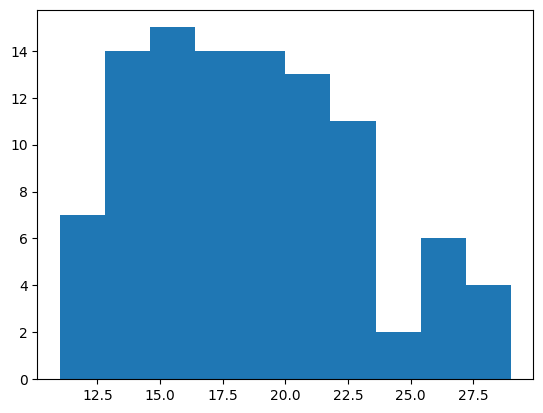

In [293]:
plt.hist(pattern_count)

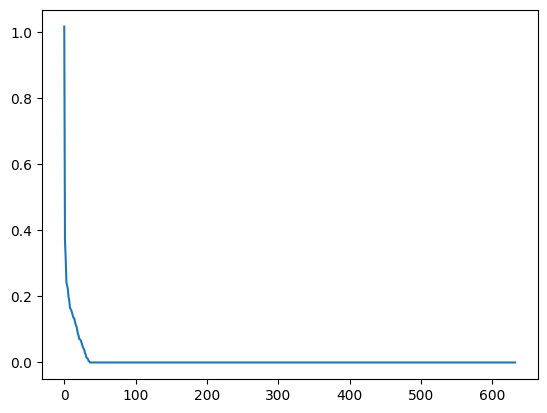

In [266]:
_,S,_ = la.svd(B_nuc_passive)
plt.plot(S)